# 2D Space - Mixed Selectivity

Let's try to get a 2D version of the code working...

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
from mpl_toolkits.mplot3d import Axes3D
import math
import optax
import scipy
import jax

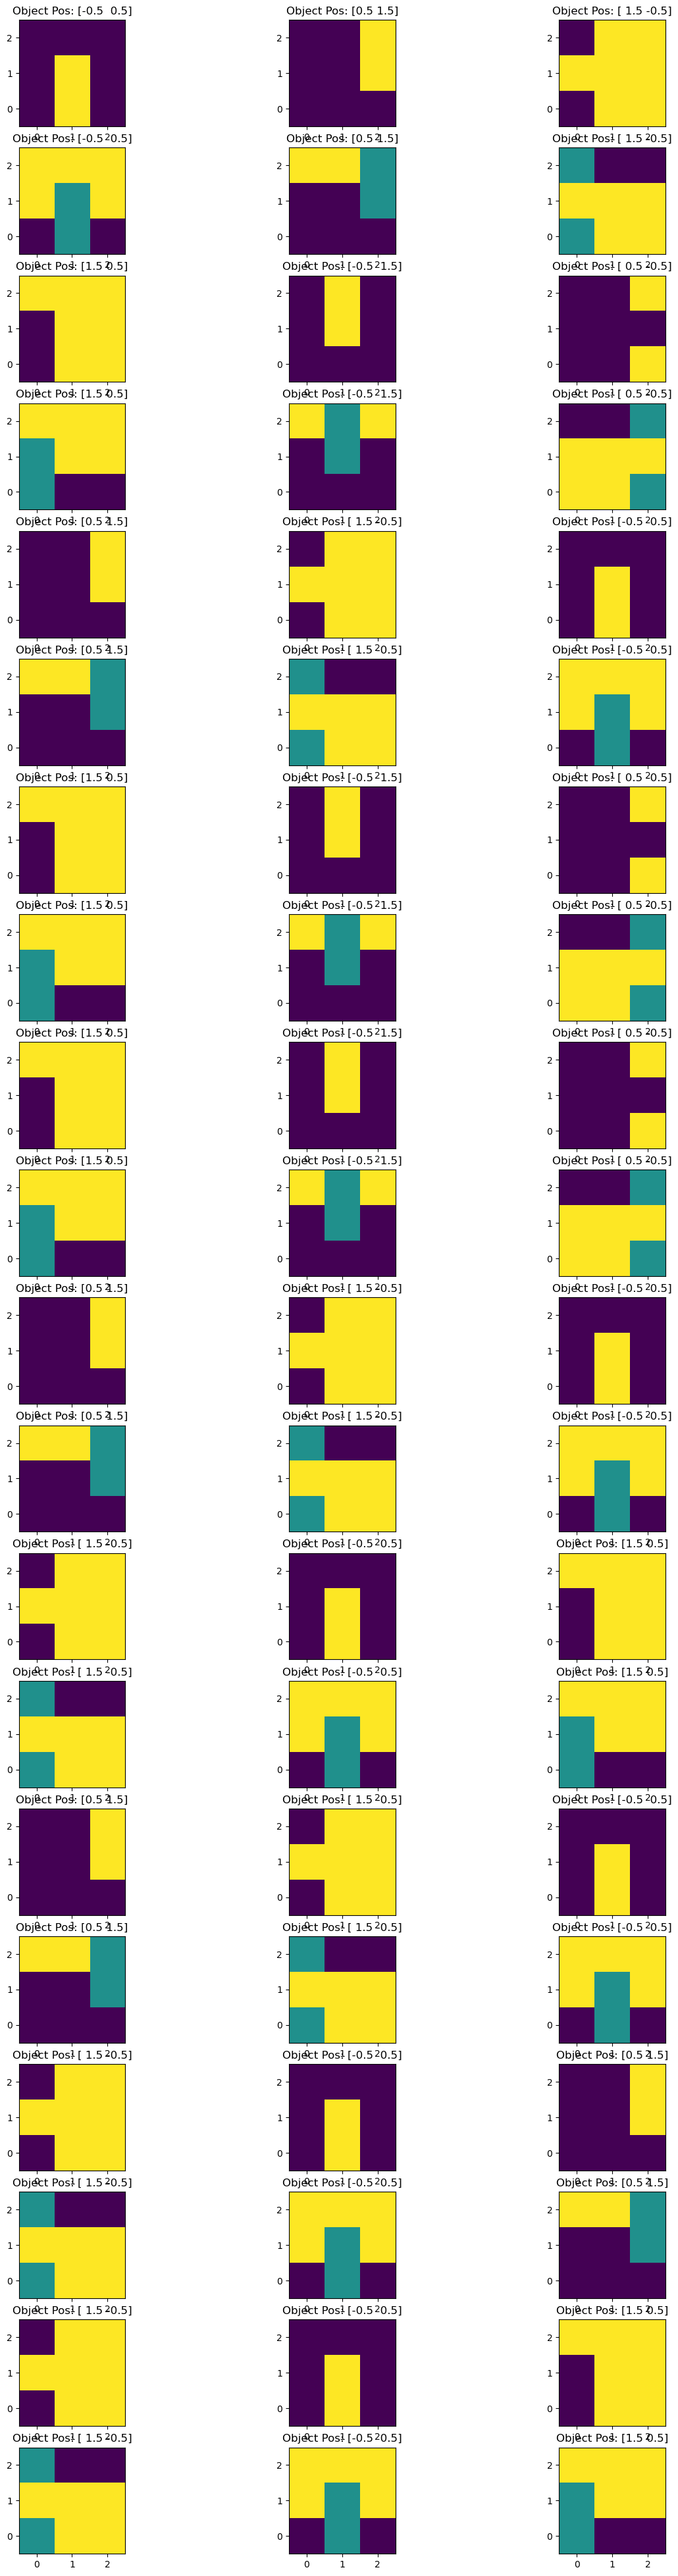

In [2]:
# First get function that generates uniformly distributed objects

num_objects = 3 # CODE IS NOT DONE FOR CHANGING THIS!
D_Sample = 10
L = 3 # CODE CURRENTLY ONLY WORKS FOR EVEN!

def generate_2D_labels(L, D_Sample):
    labels = np.zeros([2*num_objects, L, L, D_Sample])
    object_positions = np.zeros([num_objects*2, D_Sample])
    for d in range(D_Sample):
        if np.random.sample(1) < 0.5:
            object_positions[:,d] = np.random.choice(L, [num_objects*2])-0.5 # x and y position of each of the three objects
        else:
            object_positions[:2,d] = np.random.choice(L, [2])
            for object in range(1, num_objects):
                object_positions[object*2:(object+1)*2,d] = np.mod(object_positions[(object-1)*2:object*2,d] + 1, L)
            object_positions[:,d] = object_positions[:,d]-0.5

    for object in range(num_objects):
        for room in range(D_Sample):
            object_position = object_positions[object*2:(object+1)*2,room]
            for l_x in range(L):
                for l_y in range(L):
                    distance = object_position - np.array([l_x, l_y])
                    distance[distance > L/2] = distance[distance > L/2] - L
                    distance[distance < -L/2] = distance[distance < -L/2] + L
    
                    #print(object_position, np.array([l_x, l_y]), distance)
    
                    # If further to travel in x
                    if np.abs(distance[0]) > np.abs(distance[1]):
                        # And object to left, go left (0)
                        if distance[0] > 0:
                            labels[2*object, l_x, l_y, room] = -1
                        else: # Go right (1)
                            labels[2*object, l_x, l_y, room] = 1
                    # Further to go in y
                    else:
                        # And object to south, go south (2)
                        if distance[1] > 0:
                            labels[2*object+1, l_x, l_y, room] = -1
                        else: # Go north (3)
                            labels[2*object+1, l_x, l_y, room] = 1 

    return labels, object_positions

labels, object_positions = generate_2D_labels(L, D_Sample)
plot_num = 10
room_choice_plot = np.random.choice(D_Sample, [plot_num])

plt.figure(figsize = (15, 5*plot_num))
for plot in range(plot_num):
    for dim in range(2):
        for object in range(num_objects):
            plt.subplot(plot_num*2, num_objects, object + 1 + plot*num_objects*2 + dim*num_objects)
            plt.imshow(labels[object*2+dim,:,:,room_choice_plot[plot]].T, origin="lower")
            plt.title(f'Object Pos: {object_positions[object*2:(object+1)*2,room_choice_plot[plot]]}')
            #plt.yticks(ticks = np.arange(L), labels = np.flip(np.arange(L)))

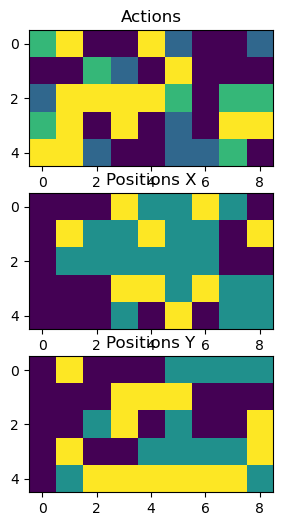

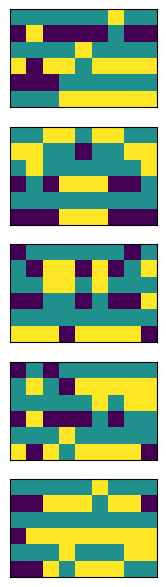

In [4]:
# Create random data to feed the network
T = L**2 # Length of each trajectory
D = 5 # How many rooms to sample

# Set up step matrix
steps = np.zeros([4, 2])
steps[0,0] = -1
steps[1,0] = 1
steps[2,1] = -1
steps[3,1] = 1

all_object_positions = np.meshgrid(np.arange(L), np.arange(L))
all_object_positions = np.stack([np.ndarray.flatten(all_object_positions[0]), np.ndarray.flatten(all_object_positions[1])]) - 0.5
all_object_positions

def generate_trajectories_random(T, D, L):
    # Set up actions, have to explore the room for the first L**2 - 1 timesteps, then random
    actions = np.random.choice(4, [T,D])
    actions = actions.astype(int)
    
    # Given actions, compute the positions
    positions = np.zeros([2, T, D])
    for t in range(1, T):
        positions[:,t,:] = np.mod(positions[:,t-1,:] + steps[actions[t-1,:]].T, L) # This is for periodic
    positions = positions.astype(int)

    labels, object_positions = generate_2D_labels(L, D)
    
    network_signals = np.zeros([2*num_objects,T,D])
    for d in range(D):
        for t in range(T):
            for input_dim in range(num_objects*2):
                network_signals[input_dim,t,d] = labels[input_dim, positions[0,t,d], positions[1,t,d],d]

    inputs = np.zeros([L**2*num_objects, D])
    for d in range(D):
        for object in range(num_objects):
            this_object_position = object_positions[object*2:(object+1)*2,d]
            one_hot_code = np.where(np.logical_and(all_object_positions[0] == this_object_position[0,None], all_object_positions[1] == this_object_position[1,None]))[0]
            inputs[object*L**2 + one_hot_code, d] = 1
            
    return actions, positions, network_signals, inputs, object_positions

actions, positions, network_signals, inputs, object_positions = generate_trajectories_random(T, D, L)

plt.figure(figsize = (20, 6))
plt.subplot(3,1,1)
plt.imshow(actions.T)
plt.title('Actions')
plt.xticks()
plt.yticks()

plt.subplot(3,1,2)
plt.imshow(positions[0,:,:].T)
plt.title('Positions X')
plt.xticks()
plt.yticks()

plt.subplot(3,1,3)
plt.imshow(positions[1,:,:].T)
plt.title('Positions Y')
plt.xticks()
plt.yticks()

plt.figure(figsize = (15,15))
plot_rows = 10
plot_cols = int(D/plot_rows)+1
for room in range(D):
    plt.subplot(plot_rows, plot_cols, room+1)
    plt.imshow(network_signals[:,:,room])
    plt.xticks([])
    plt.yticks([])

In [5]:
# Define initialising functions, and losses
num_actions = 4
 
# Initialise Ws orthogonal, and others random
def initialise_weights(N, random_seed, init_scale = 0.01):
    W = jnp.zeros([num_actions, N, N+1])
    key = random.PRNGKey(random_seed)

    for n in range(num_actions):
        key, subkey = random.split(key)
        W = W.at[n,:,-1].set(random.normal(subkey, (N,))*init_scale)

        Wp = random.normal(key, (N,N))
        Wp, S, V = jnp.linalg.svd(Wp)
        W = W.at[n,:,:N].set(Wp)

    R = random.normal(key, (2*num_objects, N+1))*init_scale
    I = random.normal(key, (N, L**2*num_objects+1))*init_scale
    params = {'W':W, 'R':R, 'I':I}
    
    return params

@jit
def generate_rep(params, inputs, actions):
    # Inputs dim x traj length x rooms, actions traj length x rooms
    g = jnp.zeros([N, T, D])
    g = g.at[:,0,:].set(params['I'][:,:-1]@inputs[:,:] + params['I'][:,-1][:,None])

    # For rest we just recurrently go around.
    for t in range(1,T):
        g = g.at[:,t,:].set(jnp.einsum('ijk,ki->ji', params['W'][actions[t-1],:,:-1],g[:,t-1,:]) + params['W'][actions[t-1],:,-1].T)
        
    return g

@jit
def loss_weight(W):
    return jnp.sum(jnp.power(W[:,:-1], 2))

@jit
def loss_act(g):
    return jnp.mean(jnp.sum(jnp.power(g, 2), 0))

@jit
def loss_pos(g):
    return jnp.mean(jnp.sum(jnn.relu(-g), 0))

@jit
def loss_fit(g, R, outputs):
    preds = jnp.einsum('ij, jkl -> ikl', R[:,:-1], g) + R[:,-1][:,None,None]
    return jnp.mean(jnp.sum(jnp.power(outputs - preds, 2), 0))

@jit
def generate_pred(params, g):
    preds = jnp.einsum('ij, jkl -> ikl', params['R'][:,:-1], g) + params['R'][:,-1][:,None,None]
    return preds

In [6]:
network_signals.shape

(6, 9, 5)

In [9]:
mu_fit = 10
mu_G = 0.01
mu_W = 0.01
mu_pos = 10
fit_thresh = 0.01

@jit
def loss(params, inputs, network_signals, actions):
    g = generate_rep(params, inputs, actions)
    
    fitting_loss = loss_fit(g, params['R'], network_signals)  
    
    weight_loss = 0
    for i in range(4):
        weight_loss += loss_weight(params['W'][i,:,:])
    weight_loss += loss_weight(params['R'])
    weight_loss += loss_weight(params['I'])
    
    return mu_fit*jnn.relu(fitting_loss-fit_thresh) + mu_G*loss_act(g) + mu_W*weight_loss + mu_pos*loss_pos(g)

@jit
def update(params, inputs, network_signals, actions, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, inputs, network_signals, actions)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

N = 64
random_seed = 53295731431
learning_rate = 1e-4 #2e-5
scale = 0.5
key = random.PRNGKey(random_seed)

re_init = 1
if re_init:
    optimizer = optax.adam(learning_rate)
    params = initialise_weights(N, random_seed, init_scale = scale)
    opt_state = optimizer.init(params)
    min_loss = np.infty
else:
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
print(loss(params, inputs, network_signals, actions))

2049.2837


In [10]:
g = generate_rep(params, inputs, actions)

def calc_acc(g, params, network_signals):
    preds = generate_pred(params, g)
    preds_classification = jnp.zeros(preds.shape)
    preds_classification = preds_classification.at[preds>0.5].set(1)
    preds_classification = preds_classification.at[preds<-0.5].set(-1)
    jnp.linalg.norm(preds_classification - network_signals)
    return jnp.sum(preds_classification == network_signals)/jnp.size(preds_classification)

calc_acc(g, params, network_signals)

Array(0.26666668, dtype=float32)

In [11]:
min_loss = np.infty

In [ ]:
num_timesteps = 100000000 # Number of steps max
resample_trajs = 1 # How often to resample

# Some mechanics
print_iter = 5000
min_this_step = 1
D = 64
T = 10

for step in range(num_timesteps):
    if step % resample_trajs == 0:
        actions, positions, network_signals, inputs, object_positions = generate_trajectories_random(T, D, L)

    params, opt_state, loss_val = update(params,  inputs, network_signals, actions, opt_state)

    if step % print_iter == 0:
        g = generate_rep(params, inputs, actions)
        
        fitting_loss = loss_fit(g, params['R'], network_signals)
        
        weight_loss_W = 0
        for i in range(4):
            weight_loss_W += loss_weight(params['W'][i,:,:])
        weight_loss_R = loss_weight(params['R'])
        weight_loss_I = loss_weight(params['I'])
        
        L_a = loss_act(g)
        L_p = loss_pos(g)
        acc = calc_acc(g, params, network_signals)

        loss_comp = mu_fit*jnn.relu(fitting_loss-fit_thresh) + mu_G*L_a + mu_W*(weight_loss_W + weight_loss_R + weight_loss_I) + mu_pos*L_p
        print(f"Step {step}, Loss: {loss_val:.5f}, Acc: {acc:.5f}, Fit: {fitting_loss:.5f}, Act: {L_a:.5f}, Wei: {weight_loss_W:.5f}, R: {weight_loss_R:.5f}, I: {weight_loss_I:.5f}, Pos: {L_p:.5f}")

        min_this_step = 0

    if loss_val < min_loss:
        params_best = params
        min_loss = loss_val
        if min_this_step == 0:
            print(f'New min! {loss_val}')
            min_this_step = 1

Step 0, Loss: 2194.40527, Acc: 0.28724, Fit: 178.45621, Act: 137.36249, Wei: 255.84283, R: 83.36832, I: 451.43704, Pos: 38.03969
New min! 2194.4052734375
Step 5000, Loss: 44.26259, Acc: 0.57891, Fit: 2.45976, Act: 47.39673, Wei: 159.32375, R: 69.17906, I: 344.94147, Pos: 1.35162
New min! 42.948001861572266
Step 10000, Loss: 19.57444, Acc: 0.74193, Fit: 1.30490, Act: 41.19524, Wei: 150.46283, R: 66.99272, I: 238.70422, Pos: 0.16239
New min! 18.020185470581055
Step 15000, Loss: 12.35508, Acc: 0.82161, Fit: 0.83625, Act: 34.01664, Wei: 143.30341, R: 64.80383, I: 148.12506, Pos: 0.01682
New min! 11.647786140441895


In [32]:
T = 2*L**2 # Length of each trajectory
D = 3 # How many rooms to sample

@jit
def generate_trajectories_random_jit(key):
    key, subkey = random.split(key)

    # Set up actions, have to explore the room for the first L**2 - 1 timesteps, then random
    actions = jnp.zeros([T, D])
    #actions = actions.at[:stereotypical_explore_pattern_len,:].set(stereotypical_explore_pattern[:,None])
    actions = actions.at[:,:].set(random.choice(key, 4, [T,D]))
    actions = actions.astype(int)
    
    # Given actions, compute the positions
    positions = jnp.zeros([2, T, D])
    for t in range(1, T):
        positions = positions.at[:,t,:].set(jnp.mod(positions[:,t-1,:] + steps[actions[t-1,:]].T, L)) # This is for periodic
    positions = positions.astype(int)

    labels = jnp.zeros([2*num_objects, L, L, D_Sample])
    object_positions = random.choice(subkey, L, [num_objects*2, D_Sample])-0.5 # x and y position of each of the three objects

    for object in range(num_objects):
        for room in range(D_Sample):
            object_position = object_positions[object*2:(object+1)*2,room]
            for l_x in range(L):
                for l_y in range(L):
                    distance = object_position - jnp.array([l_x, l_y])
                    distance = distance.at[:].set(jnp.where(distance > L/2, distance - L, distance))
                    distance = distance.at[:].set(jnp.where(distance < -L/2, distance + L, distance))
                    
                    #print(object_position, np.array([l_x, l_y]), distance)
    
                    # If further to travel in x
                    offset = jax.lax.select(jnp.abs(distance[0]) > jnp.abs(distance[1]), 0, 1)
                    # And object to left, go left (0)
                    labels = labels.at[2*object+offset, l_x, l_y, room].set(jnp.sign(distance[offset]))
    
    network_signals = jnp.zeros([2*num_objects,T,D])
    for d in range(D):
        for t in range(T):
            for input_dim in range(num_objects*2):
                network_signals = network_signals.at[input_dim,t,d].set(labels[input_dim, positions[0,t,d], positions[1,t,d],d])
        
    return actions, positions, network_signals, object_positions, key

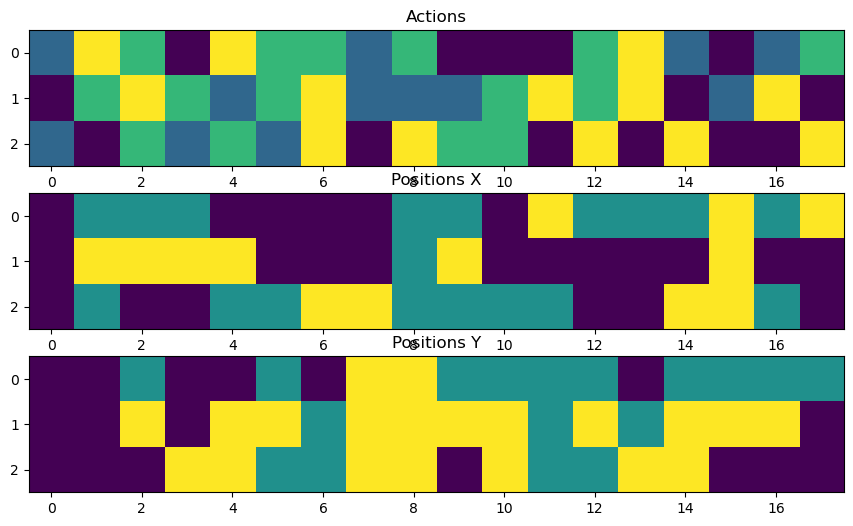

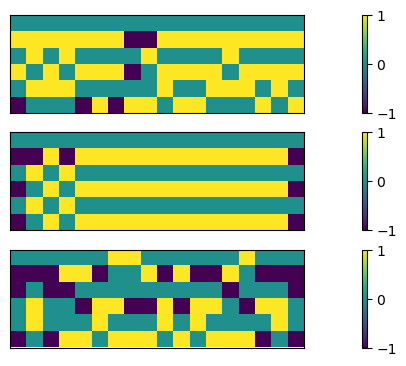

In [33]:
actions, positions, network_signals,inputs, object_positions = generate_trajectories_random(T, D, L)
plt.figure(figsize = (20, 6))
plt.subplot(3,1,1)
plt.imshow(actions.T)
plt.title('Actions')
plt.xticks()
plt.yticks()

plt.subplot(3,1,2)
plt.imshow(positions[0,:,:].T)
plt.title('Positions X')
plt.xticks()
plt.yticks()

plt.subplot(3,1,3)
plt.imshow(positions[1,:,:].T)
plt.title('Positions Y')
plt.xticks()
plt.yticks()

plt.figure(figsize = (15,15))
plot_rows = 10
plot_cols = int(D/plot_rows)+1
for room in range(D):
    plt.subplot(plot_rows, plot_cols, room+1)
    plt.imshow(network_signals[:,:,room])
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

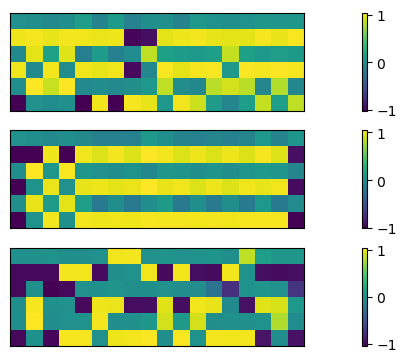

In [34]:
g = generate_rep(params_best, inputs, actions)
preds = generate_pred(params, g)

plt.figure(figsize = (15,15))
plot_rows = 10
plot_cols = int(D/plot_rows)+1
for room in range(D):
    plt.subplot(plot_rows, plot_cols, room+1)
    plt.imshow(preds[:,:,room])
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

In [122]:
# IT LEARNT!!!

In [176]:
np.save('./data/best_periodic_VI.npy',params_best)

(6, 32, 3)